Project root added to sys.path: d:\Handwritten Digit Recognition
Epoch 1/3


d:\Handwritten Digit Recognition\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 - 6s - 143ms/step - accuracy: 0.7314 - loss: 0.8859
Epoch 2/3
40/40 - 4s - 91ms/step - accuracy: 0.9136 - loss: 0.2910
Epoch 3/3
40/40 - 4s - 91ms/step - accuracy: 0.9498 - loss: 0.1786
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

 Test Accuracy: 0.9609
⏱ Training time: 13.06 sec
⏱ Prediction time: 2.60 sec

 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.99      0.97      0.98      1135
           2       0.94      0.96      0.95      1032
           3       0.95      0.97      0.96      1010
           4       0.99      0.94      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.97      0.97       958
           7       0.97      0.92      0.95      1028
           8       0.92      0.97      0.94       974
           9       0.93      0.95      0.94      1009

    accuracy                           0.96     10000
   macro avg 

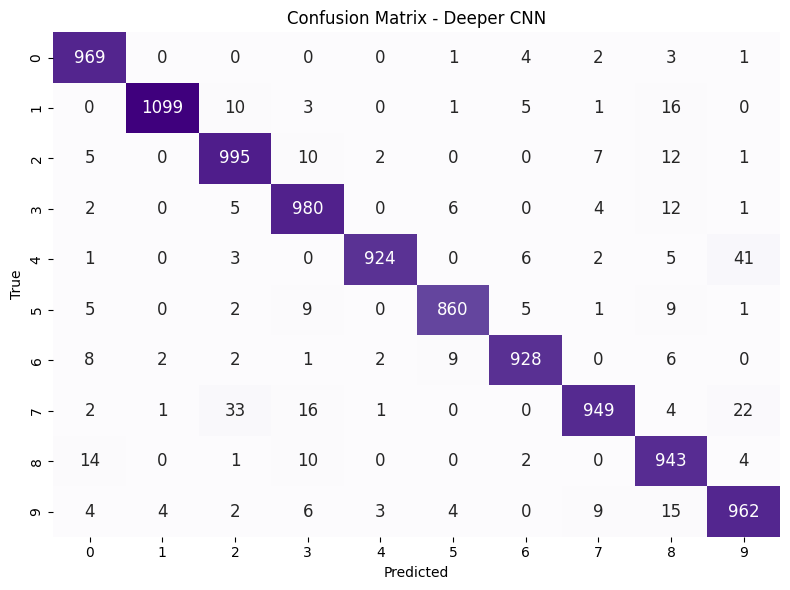

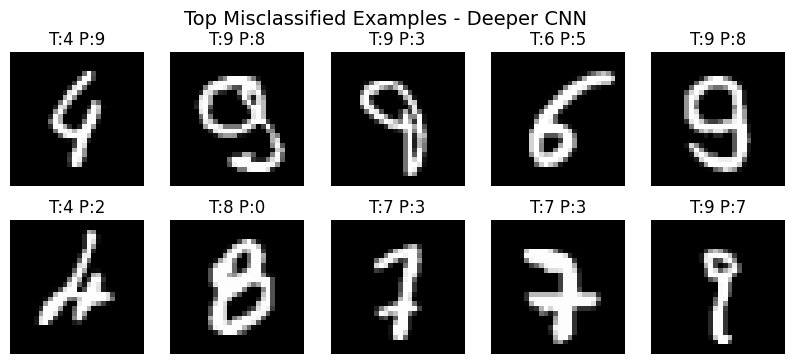

In [7]:
%run ../utils/init_notebook.py

from utils.data_loader import load_mnist
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Load data (raw pixels, no normalization)
X_train, y_train, X_test, y_test = load_mnist(normalise=False)

# Take a subset
subset_size = 5000
X_train_sub = X_train[:subset_size]
y_train_sub = y_train[:subset_size]

# Reshape for CNN input
X_train_cnn = X_train_sub.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train_cat = to_categorical(y_train_sub, 10)
y_test_cat = to_categorical(y_test, 10)

# Deeper CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_train = time.time()
model.fit(X_train_cnn, y_train_cat, epochs=3, batch_size=128, verbose=2)
end_train = time.time()

start_pred = time.time()
y_pred_prob = model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_prob, axis=1)
end_pred = time.time()

acc_cnn = accuracy_score(y_test, y_pred_cnn)
print(f"\n Test Accuracy: {acc_cnn:.4f}")
print(f"⏱ Training time: {end_train - start_train:.2f} sec")
print(f"⏱ Prediction time: {end_pred - start_pred:.2f} sec")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_cnn))

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Purples", cbar=False, annot_kws={"size": 12})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Deeper CNN")
plt.tight_layout()
plt.show()

misclassified_idx_cnn = np.where(y_pred_cnn != y_test)[0]
plt.figure(figsize=(10, 4))
for i, idx in enumerate(misclassified_idx_cnn[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx], cmap='gray')
    plt.title(f"T:{y_test[idx]} P:{y_pred_cnn[idx]}")
    plt.axis('off')
plt.suptitle("Top Misclassified Examples - Deeper CNN", fontsize=14)
plt.show()
